In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import functions as funcs
import pyemma as pm
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import numpy as np
import functions as funcs
import pymc3 as pm
import scipy as sp
import pickle

In [3]:
def fit(data, dep_var, ind_vars, formula, input_space, bayes_kws):
    # determin min/max values for scaling function
    dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
    output_space = {'dep_var': dep_range}
    var_space = input_space.copy()
    var_space.update({dep_var: output_space['dep_var']})
    
    # Create scaler
    vs = funcs.create_grid(var_space)
    vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
    _, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

    # Scale data
    y, X = funcs.create_dmatrices(data, formula=formula)
    data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
    # GP data and priors
    dep_var_cols = [x for x in data_s.columns if dep_var in x]
    ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
    y =  data_s.loc[:, dep_var_cols]
    X =  data_s.loc[:, ind_var_cols]
    l_prior = funcs.gamma(2, 0.5)
    eta_prior = funcs.hcauchy(2)
    sigma_prior = funcs.hcauchy(2)
    
    
    gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                    l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                    kernel_type='exponential',  # Kernel
                                    prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

    results = {'gp': gp, 'trace': trace, 'model': model, 'data': data}
    return results


def get_data(data_sets, dep_var, ind_vars, protein, feature, num_its=None, transform=None):
    
    data = data_sets[dep_var].copy()
    ix = (data.protein==protein) & (data.feature__value==feature)
    if dep_var == 'timescale':
        ix = ix & (data.num_its == num_its)
    if feature == 'distances':
        if transform is None:
            raise ValueError('For distance feature you must specify a transform')
        ix = ix & (data.distances__transform == transform)
        
    data = data.loc[ix, [dep_var]+ind_vars]
    return data
 

# Introduction

This notebook selects the most poorly performing model (in terms of the number of divergences) and will try to diagnose and fix the problem. I will be following the advice in [this PyMC3 tutorial](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html). 

## Find diverging models

In [4]:
model_paths = Path('sensitivities_exp_log_outcome').glob('*.pkl')
for path in model_paths:
    result = pickle.load(path.open('rb'))
    divergent = result['trace']["diverging"]
    if divergent.nonzero()[0].size > 0:
        print(path.stem, divergent.nonzero()[0].size)

2jof_distances_logistic_timescale_its_2_sensitivity 1
uvf_distances_logistic_timescale_its_3_sensitivity 1
2f4k_dihedrals_timescale_its_2_sensitivity 6
2jof_dihedrals_vamp_sensitivity 1


In [18]:
results = pickle.load(Path('sensitivities_exp_log_outcome/2f4k_dihedrals_timescale_its_2_sensitivity.pkl').open('rb'))
results2 = pickle.load(Path('sensitivities_exp_log_outcome/2jof_distances_logistic_timescale_its_2_sensitivity.pkl').open('rb'))
results3 = pickle.load(Path('sensitivities_exp_log_outcome/uvf_distances_logistic_timescale_its_3_sensitivity.pkl').open('rb'))
results4 = pickle.load(Path('sensitivities_exp_log_outcome/2jof_dihedrals_vamp_sensitivity.pkl').open('rb'))


## 2f4k_dihedrals_timescale_its_2_sensitivity

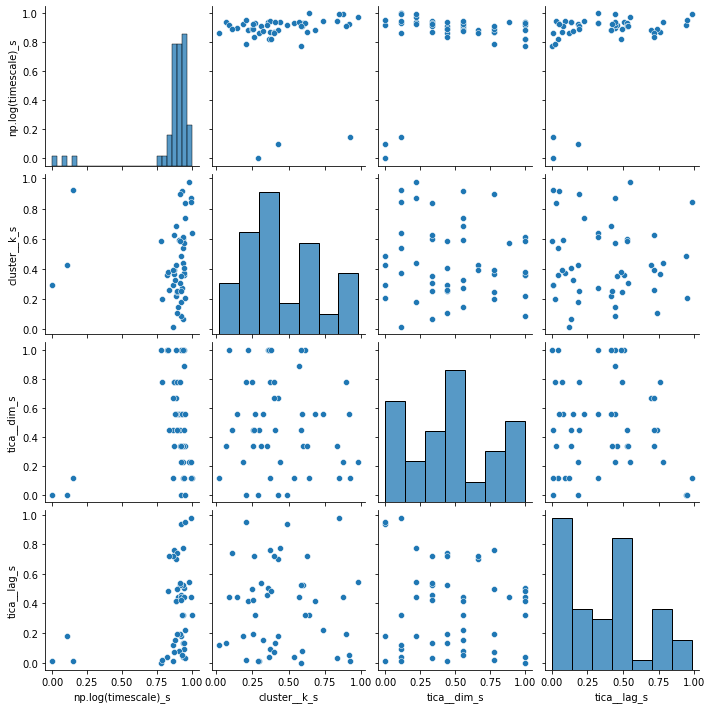

In [6]:
sns.pairplot(results['data'])

In [8]:
df = pd.read_hdf('timescales.h5')
df['feature'] = df.apply(lambda x: 'dihedrals' if x['feature__value'] == 'dihedrals' else f"{x['feature__value']}_{x['distances__transform']}", axis=1)
df = df.loc[(df.protein=='Villin') & (df.num_its <= 4), ['value', 'num_its', 'iteration','feature', 'lag',  'hp_index']]

In [9]:
ts = df.groupby(['num_its','feature', 'hp_index', 'lag'], as_index=False).median()
ts.drop(labels='iteration', axis=1, inplace=True)

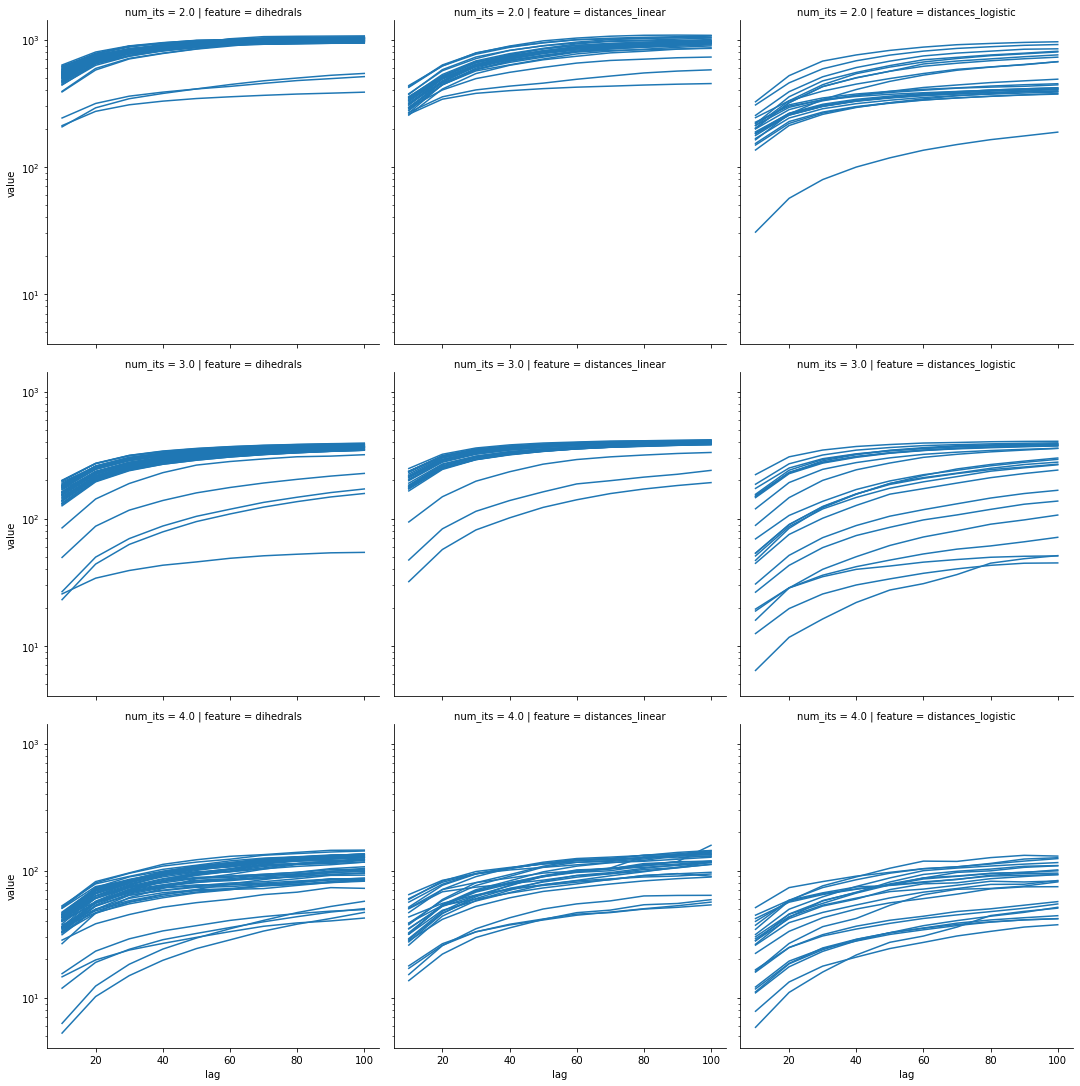

In [10]:
# g = sns.FacetGrid(ts, row='num_its', col='feature', margin_titles=True)
# g.map(sns.lineplot, 'lag', 'value')
# g.set(yscale='log')

g = sns.relplot(data=ts, x='lag', y='value', row='num_its', col='feature', units='hp_index', kind='line', estimator=None)
g.set(yscale='log')

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[<AxesSubplot:ylabel='l_cluster__k_s'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='l_tica__dim_s'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='l_tica__lag_s'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='eta', ylabel='sigma_n'>,
        <AxesSubplot:xlabel='l_cluster__k_s'>,
        <AxesSubplot:xlabel='l_tica__dim_s'>,
        <AxesSubplot:xlabel='l_tica__lag_s'>]], dtype=object)

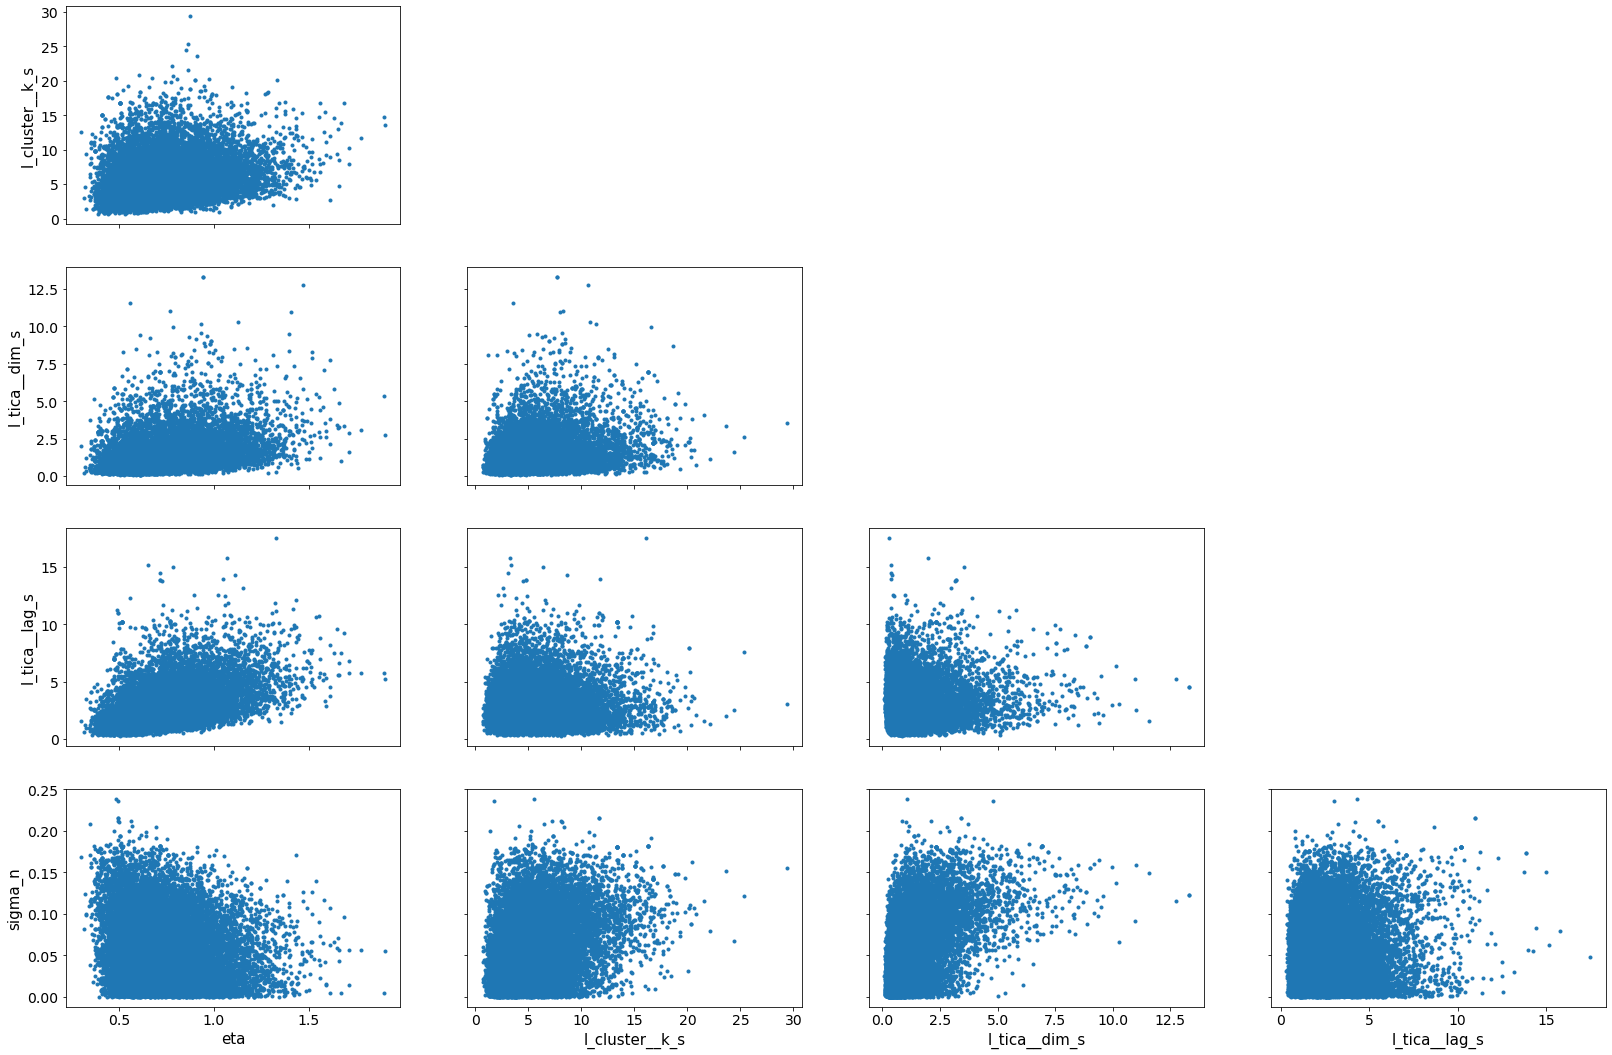

In [11]:
pm.plots.plot_pair(results['trace'])

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

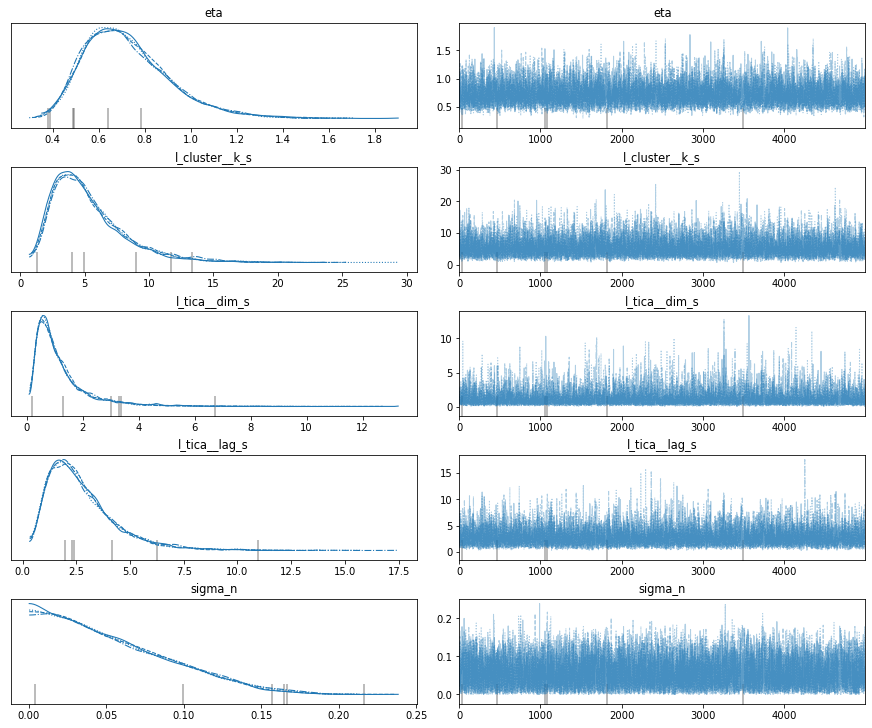

In [12]:
pm.plot_trace(results['trace'])

In [13]:
results['data'].head()

np.log(timescale)_s  cluster__k_s  tica__dim_s  tica__lag_s
1798             0.874374      0.369388     0.777778     0.757576
1799             0.867642      0.293878     0.444444     0.010101
1800             0.935397      0.536735     0.111111     0.040404
1801             0.919431      0.487755     0.000000     0.939394
1804             0.939265      0.069388     0.333333     0.131313

In [16]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
data_s = results['data']



y =  data_s.loc[:, data_s.columns[0]]
X =  data_s.loc[:, data_s.columns[1:]]
l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)

bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.95)

gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                kernel_type='exponential',  # Kernel
                                prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '97030' (I am process '96970')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '97030' (I am process '96996')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '97030' (I am process '96970')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '96996' (I am process '96970')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i3

In [23]:
pickle.dump(file=Path('sensitivities_exp_log_outcome/2f4k_dihedrals_timescale_its_2_sensitivity_ar95.pkl').open('wb'), 
            obj={'model': model, 'trace': trace, 'gp': gp, "data": results['data']})

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

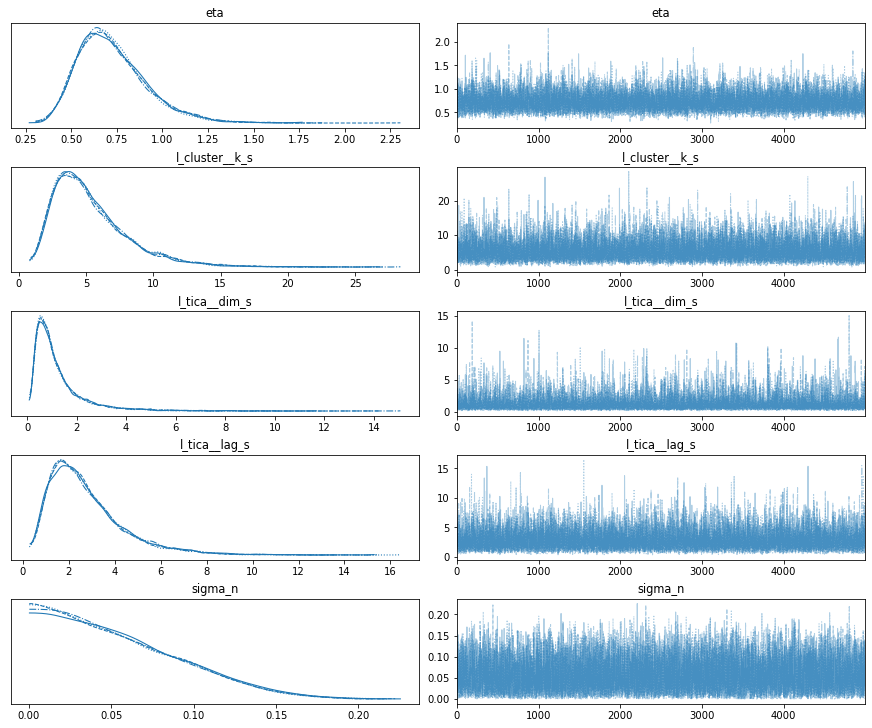

In [17]:
pm.plot_trace(trace)

## 2jof_distances_logistic_timescale_its_2_sensitivity

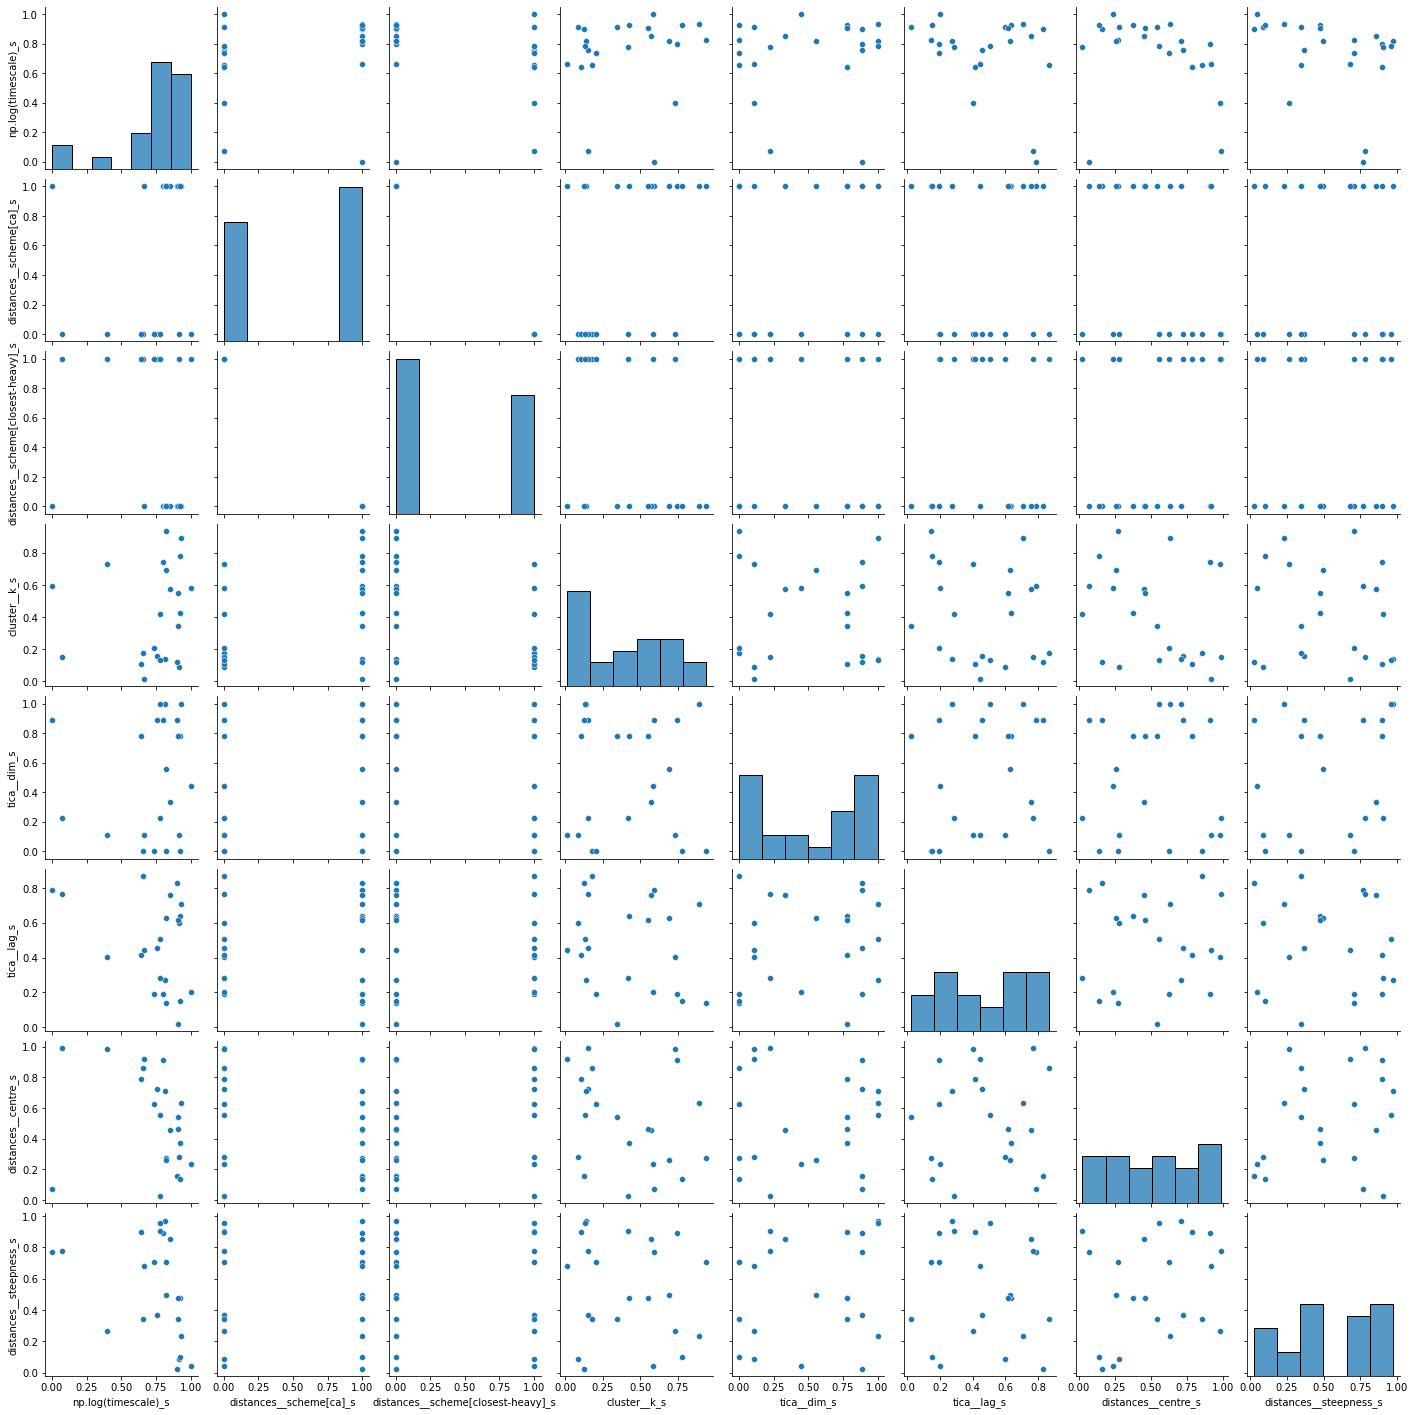

In [31]:
sns.pairplot(results2['data'], corner=False)

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'l_distances__centre_s'}>,
        <AxesSubplot:title={'center':'l_distances__centre_s'}>],
       [<AxesSubplot:title={'center':'l_distances__steepness_s'}>,
        <AxesSubplot:title={'center':'l_distances__steepness_s'}>],
      

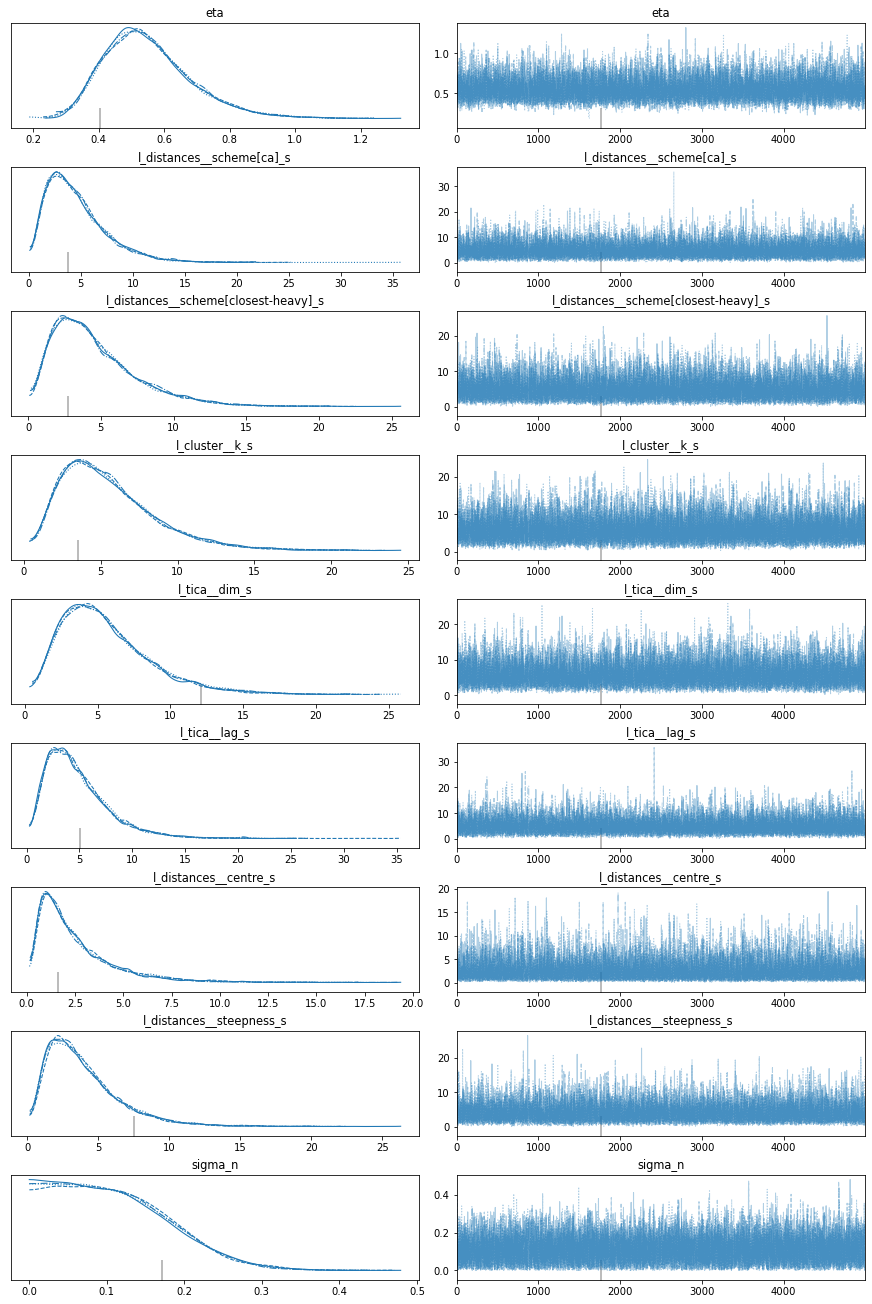

In [21]:
pm.plot_trace(results2['trace'])

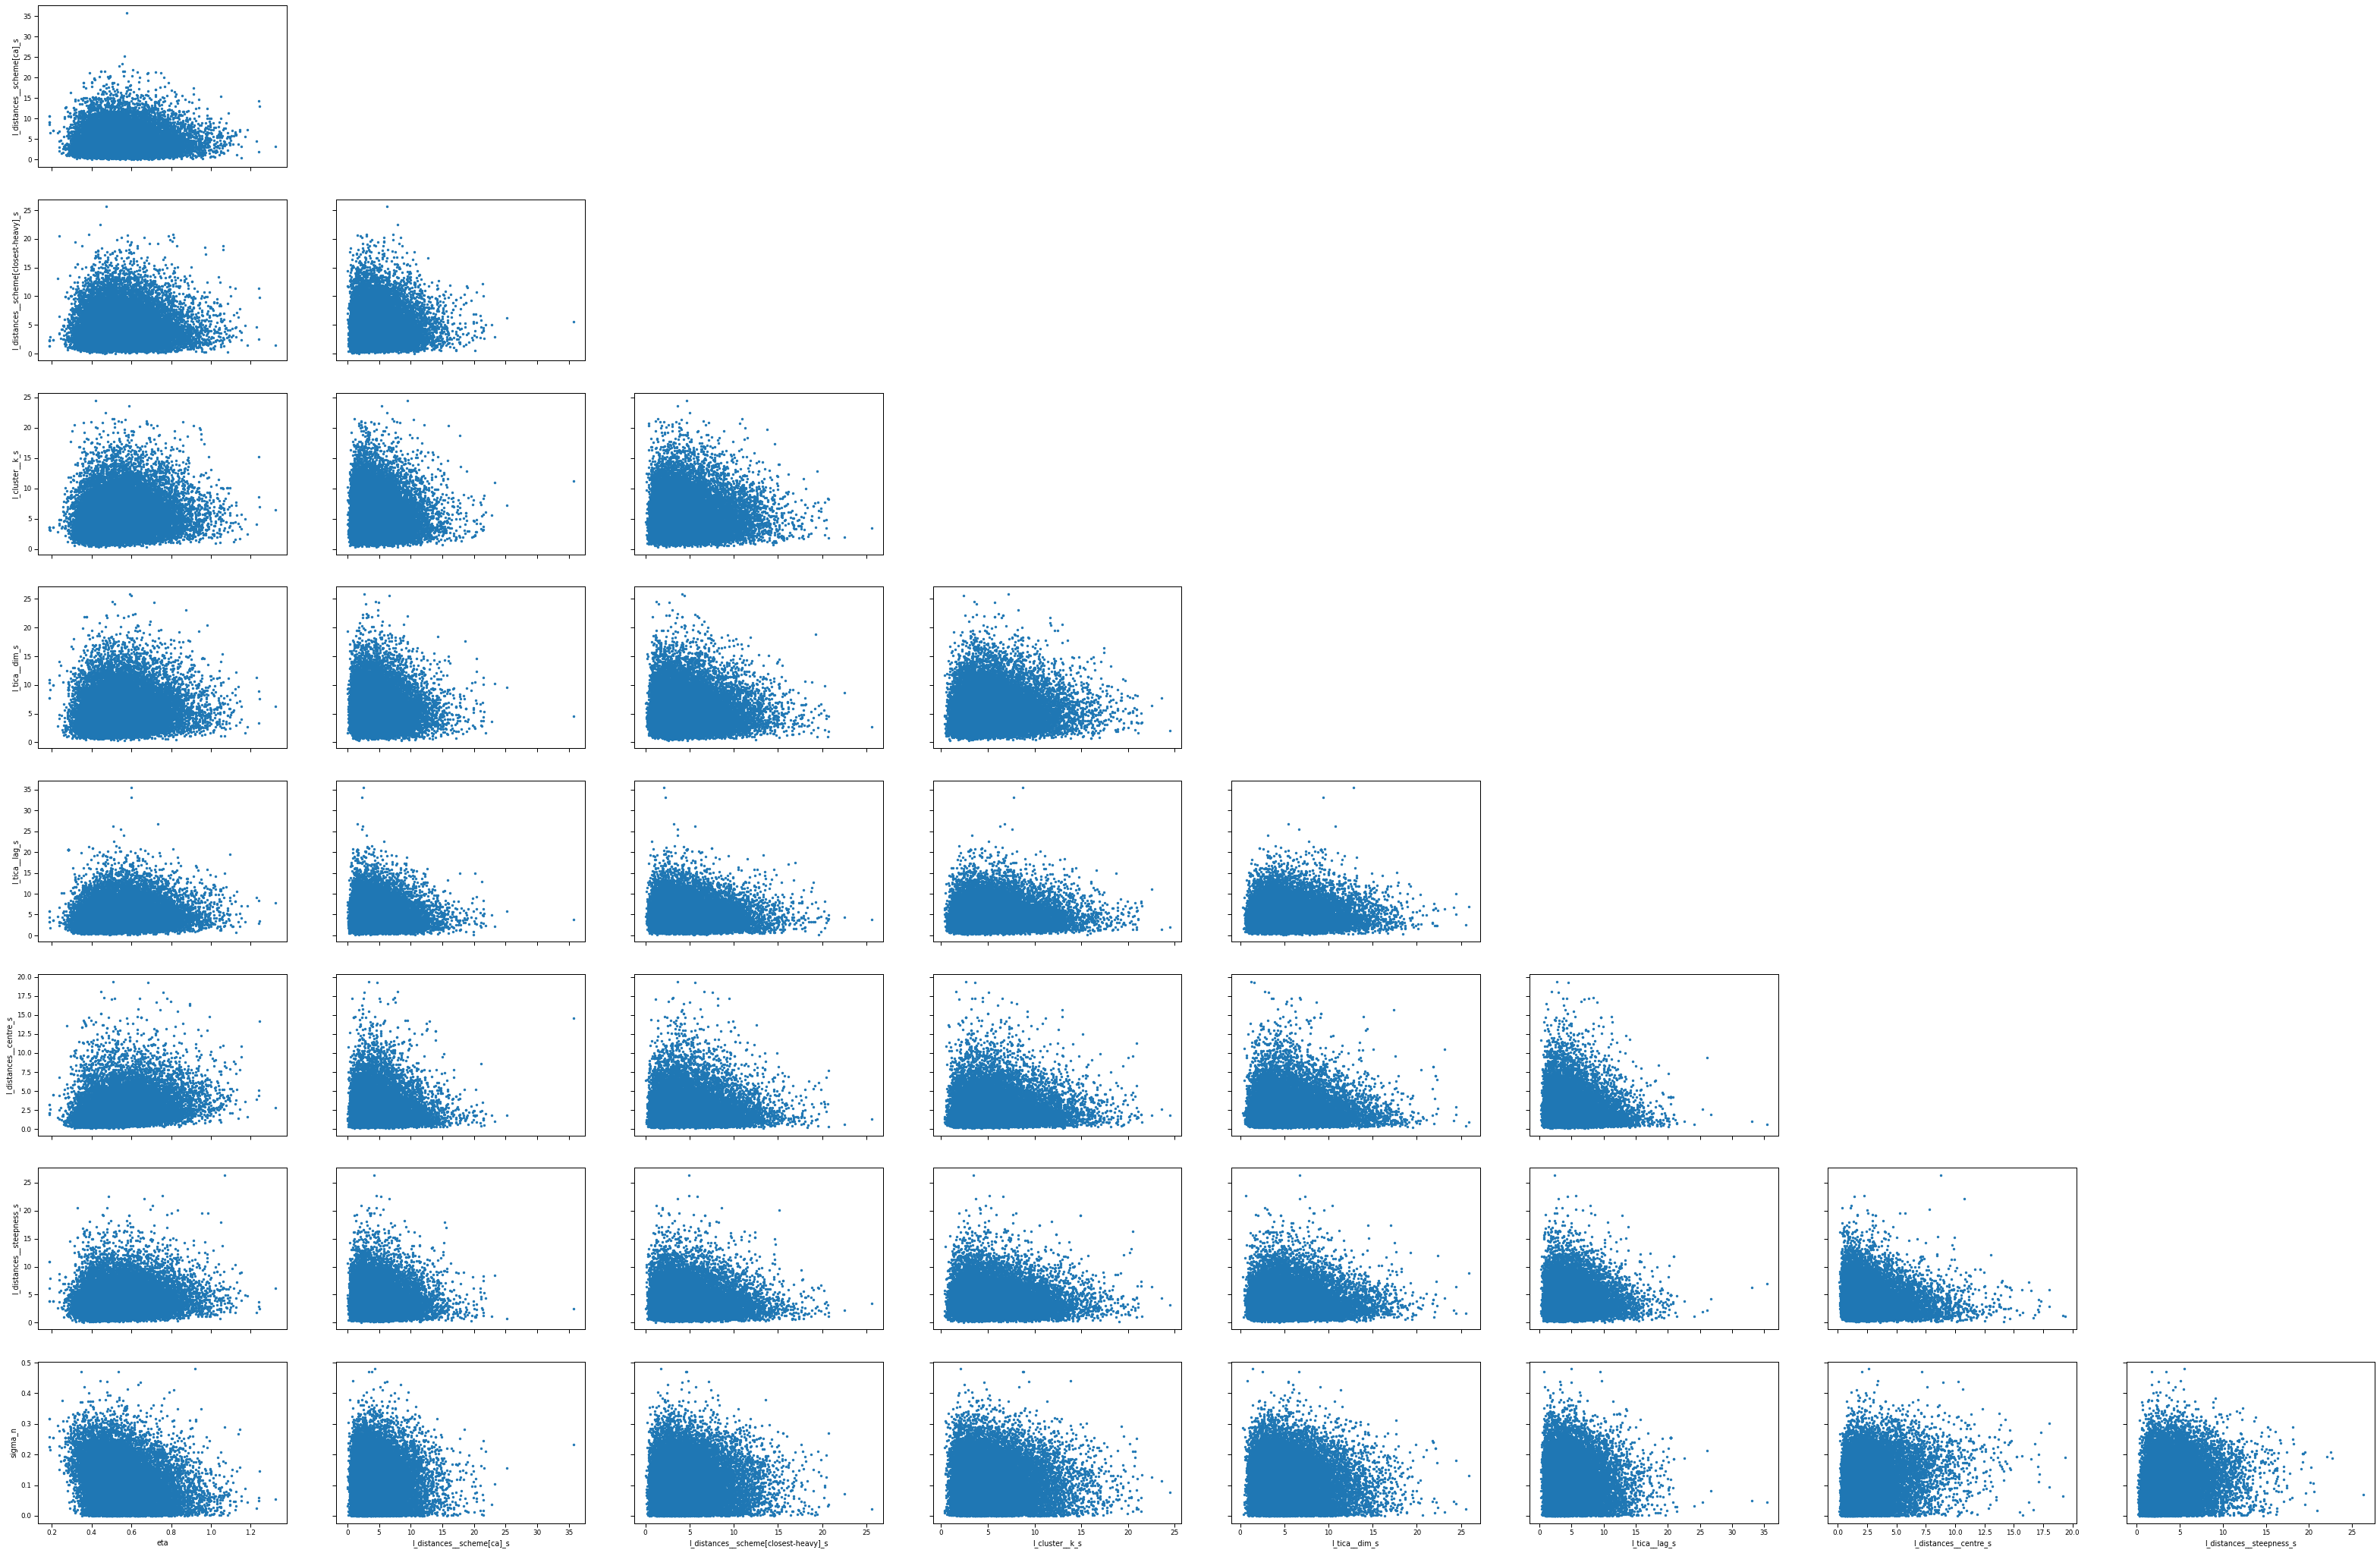

In [22]:
with sns.plotting_context('paper'):
    pm.plots.plot_pair(results2['trace'])

In [24]:
data_s = results2['data']
y =  data_s.loc[:, data_s.columns[0]]
X =  data_s.loc[:, data_s.columns[1:]]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)

bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.95)

gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                kernel_type='exponential',  # Kernel
                                prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

pickle.dump(file=Path('sensitivities_exp_log_outcome/2jof_distances_logistic_timescale_its_2_sensitivity_ar95.pkl').open('wb'), 
            obj={'model': model, 'trace': trace, 'gp': gp, "data": results['data']})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_distances__steepness_s, l_distances__centre_s, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '1296' (I am process '1239')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1296' (I am process '1261')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1239' (I am process '1261')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

## uvf_distances_logistic_timescale_its_3_sensitivity

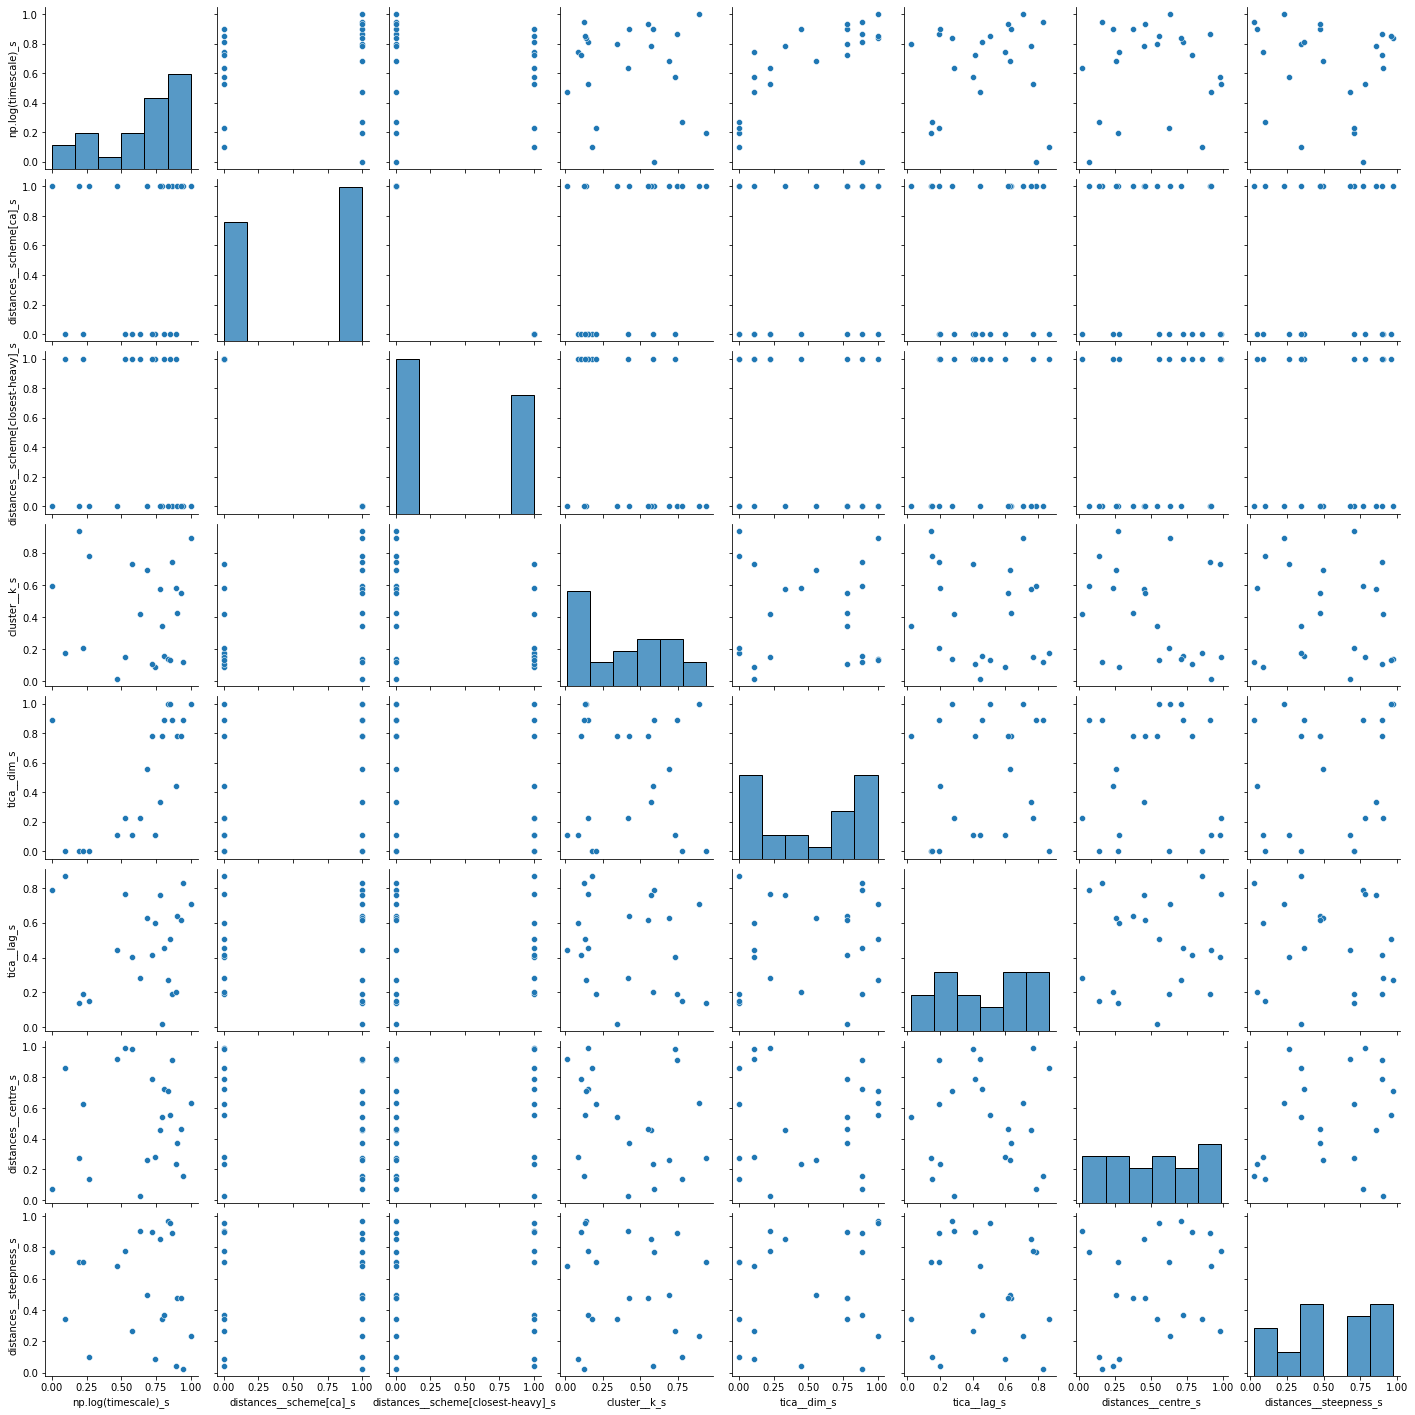

In [32]:
sns.pairplot(results3['data'])

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'l_distances__centre_s'}>,
        <AxesSubplot:title={'center':'l_distances__centre_s'}>],
       [<AxesSubplot:title={'center':'l_distances__steepness_s'}>,
        <AxesSubplot:title={'center':'l_distances__steepness_s'}>],
      

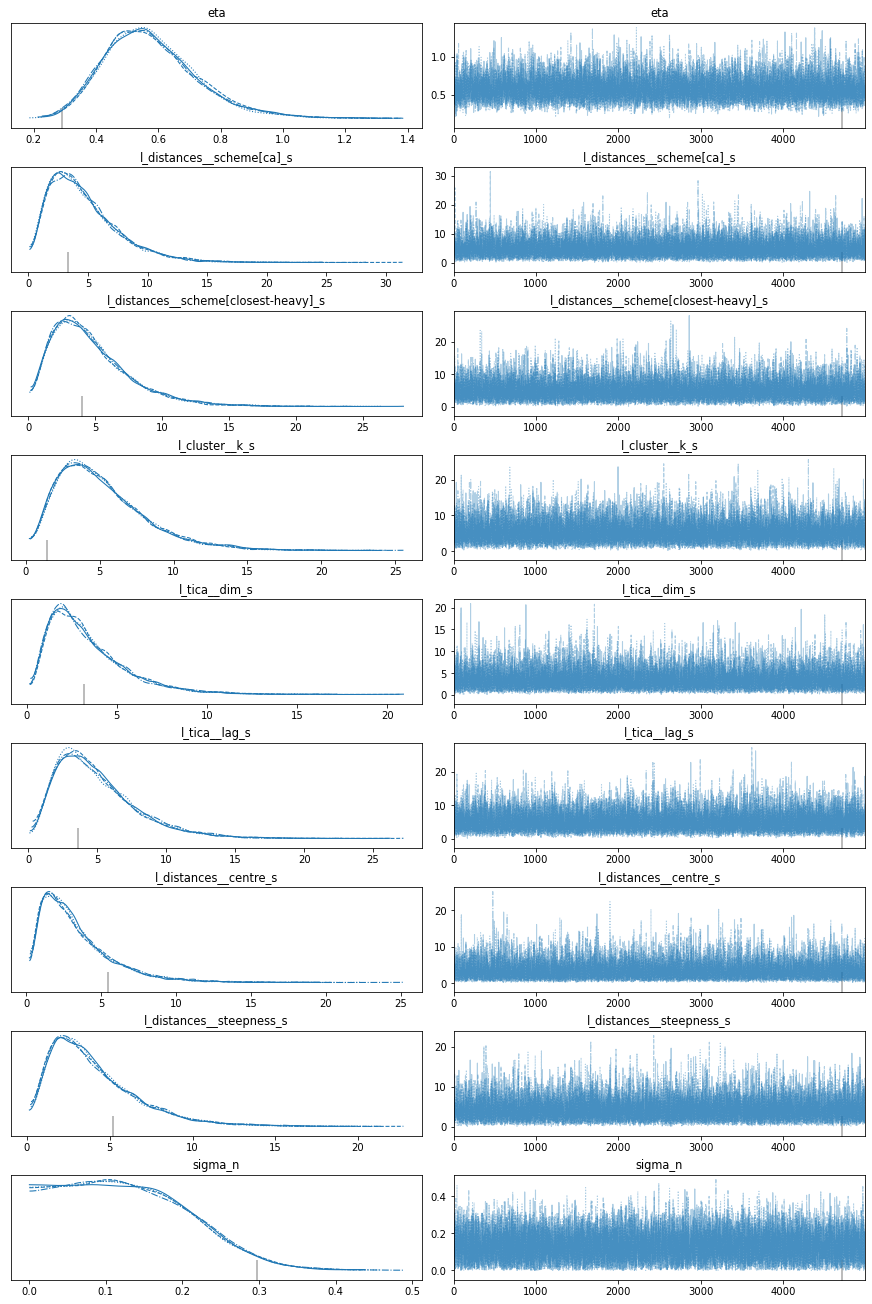

In [27]:
pm.plot_trace(results3['trace'])

In [28]:
data_s = results3['data']

y =  data_s.loc[:, data_s.columns[0]]
X =  data_s.loc[:, data_s.columns[1:]]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)

bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.95)

gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                kernel_type='exponential',  # Kernel
                                prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

pickle.dump(file=Path('sensitivities_exp_log_outcome/uvf_distances_logistic_timescale_its_3_sensitivity_ar95.pkl').open('wb'), 
            obj={'model': model, 'trace': trace, 'gp': gp, "data": results['data']})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_distances__steepness_s, l_distances__centre_s, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '1764' (I am process '1706')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eit

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'l_distances__centre_s'}>,
        <AxesSubplot:title={'center':'l_distances__centre_s'}>],
       [<AxesSubplot:title={'center':'l_distances__steepness_s'}>,
        <AxesSubplot:title={'center':'l_distances__steepness_s'}>],
      

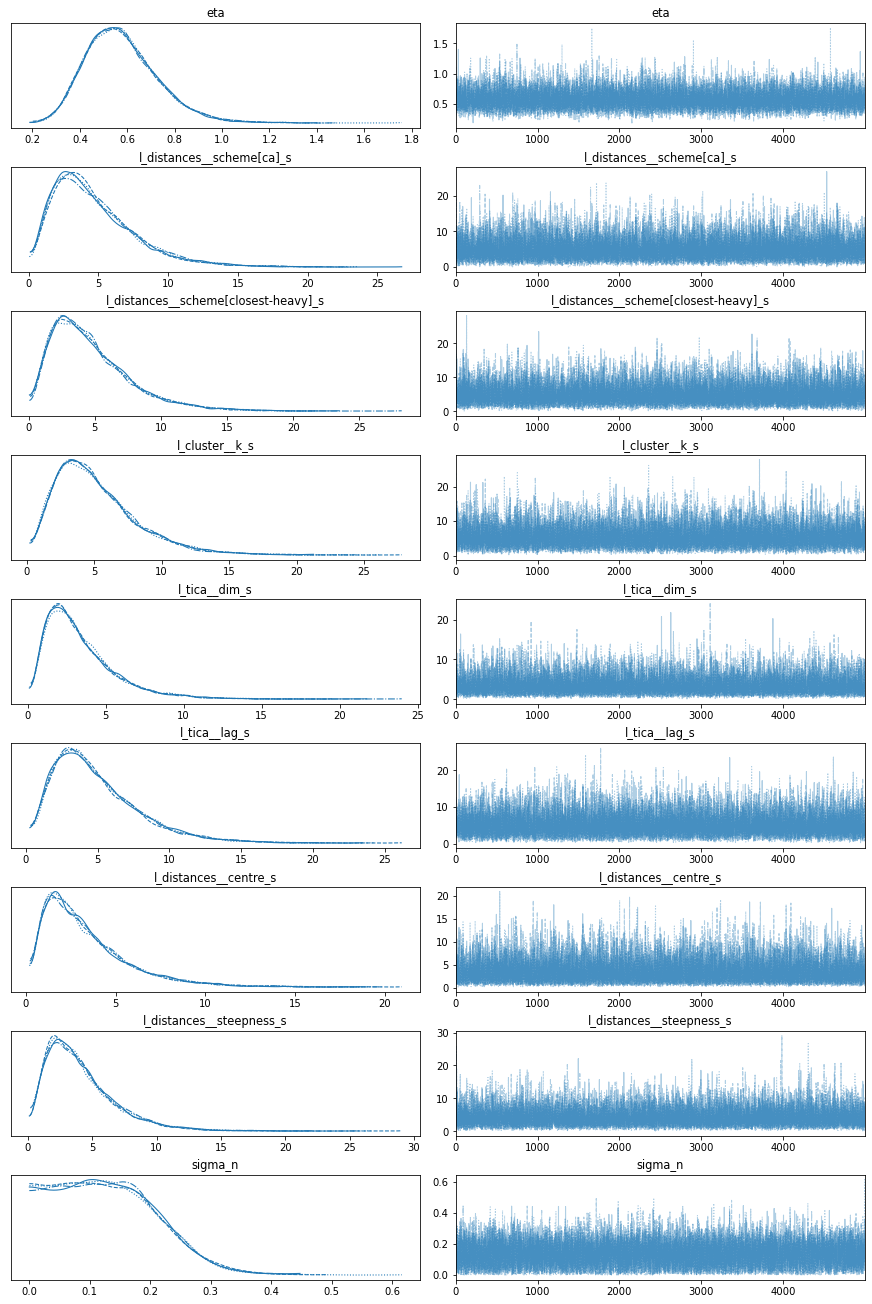

In [29]:
pm.plot_trace(trace)

## 2jof_dihedrals_vamp_sensitivity

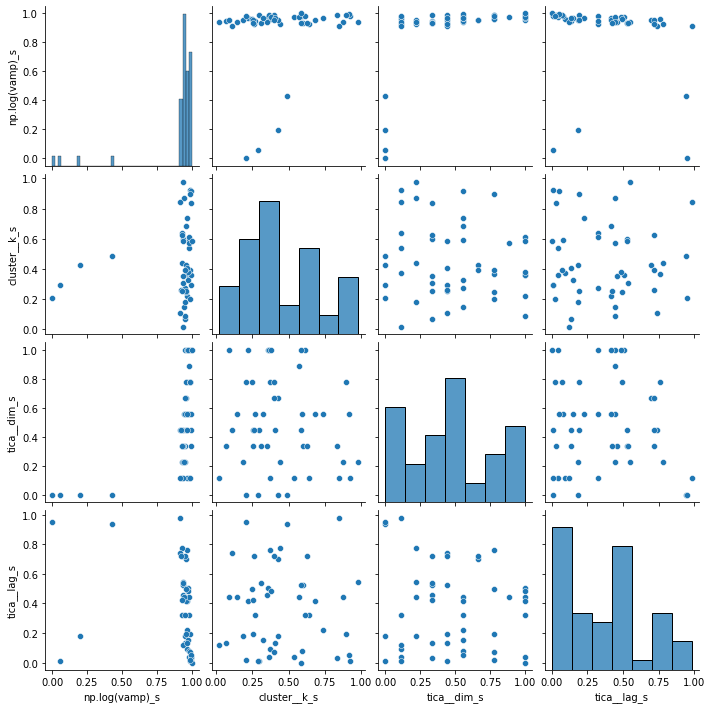

In [30]:
sns.pairplot(results4['data'])

In [33]:
data_s = results4['data']

y =  data_s.loc[:, data_s.columns[0]]
X =  data_s.loc[:, data_s.columns[1:]]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)

bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.95)

gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                kernel_type='exponential',  # Kernel
                                prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

pickle.dump(file=Path('sensitivities_exp_log_outcome/2jof_dihedrals_vamp_sensitivity_ar95.pkl').open('wb'), 
            obj={'model': model, 'trace': trace, 'gp': gp, "data": results['data']})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '2343' (I am process '2285')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2343' (I am process '2311')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2343' (I am process '2311')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2285' (I am process '2311')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit